# Библиотека AEON (Бывшая SKTIME) 

Библиотеки [<b>aeon<b>](https://www.aeon-toolkit.org/) и [<b>Scikit-Time</b> (<b><code>Sktime</code></b> )](https://www.sktime.org/en/stable/index.html) — это набор инструментов Python с [открытым исходным кодом](https://github.com/alan-turing-institute/sktime) для работы временными рядами. В основном библиотеки предполагает использование методов машинного обучения. 
Библиотеки расширяет `API scikit-learn` для задач временных рядов. Он предоставляет необходимые алгоритмы и инструменты преобразования для эффективного решения задач регрессии, прогнозирования и классификации. Библиотека включает специальные алгоритмы обучения временных рядов и методы преобразования.  

Если у вас не установленна данная библиотека, давайте установим ее при помощи следующего кода. Рекомендации по установке можно найти в официальной документации [тут](https://www.aeon-toolkit.org/en/latest/installation.html). 

Отметим, что хоть мы и указываем тут код для установки компонент sktime, в общем случае рекомендуем установить полную версию пакета с использованием командной строки. Например, для этого можно использовать следующий скрипт
```python
pip install --upgrade aeon[all_extras]
```

In [2]:
# try:
#     import aeon
# except:
# #     !pip install sktime --user
# #     !pip install pmdarima
# #     !pip install statsmodels
# #     !pip install prophet
#     !pip install --upgrade aeon[all_extras]
# import aeon

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [4]:
import aeon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
from aeon.forecasting.model_selection import temporal_train_test_split
from aeon.forecasting.base import ForecastingHorizon
from aeon.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from aeon.forecasting.model_evaluation import evaluate
from aeon.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from aeon.forecasting.exp_smoothing import ExponentialSmoothing
from aeon.forecasting.naive import NaiveForecaster
from aeon.forecasting.theta import ThetaForecaster
from aeon.forecasting.trend import PolynomialTrendForecaster
from aeon.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from aeon.transformations.detrend import Deseasonalizer, Detrender
from aeon.utils.plotting import plot_series
from aeon.forecasting.compose import TransformedTargetForecaster


from aeon.forecasting.fbprophet import Prophet
from aeon.forecasting.tbats import TBATS
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier



r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

В качестве набора данных давайте загрузим рассмотренный ранее набор данных о потреблении электричества в Германии. 

In [6]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
df=df.fillna(df.mean())
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,1088.317,325.165,103.386051,371.25795
2015-01-02,1246.588,603.554,7.757000,611.31100
2015-01-03,1117.554,462.955,7.237000,470.19200
2015-01-04,1081.980,385.023,19.982000,405.00500
2015-01-05,1325.920,216.540,26.522000,243.06200


В первую очередь в данном уроке мы будем рассматривать однопеременные методы (`univariate time series`). Поэтому выберем один из столбцов данных в качестве отдельного временного ряда. 

Кроме того, в ходе предыдущего анализа было установлено, что ряд имеет как минимум 2 составляющие (быструю, с периодом неделя и медленную с периодом 1 год). Для упрощения анализа и без значительных потерь значимости удалим быструю составляющую при помощи перегруппировки данных.

In [7]:
y = df.Consumption.asfreq('7d')
# y.index = pd.PeriodIndex(y.index) # pd.to_datetime(y.index)
y.head()

Date
2015-01-01    1088.317
2015-01-08    1474.375
2015-01-15    1479.245
2015-01-22    1496.905
2015-01-29    1508.443
Freq: 7D, Name: Consumption, dtype: float64

In [8]:
# В качестве альтернативы можно бы было использовать resample('7d'), 
# но в этом случае пришлось бы дополнительно использовать следующую функцию.
# def add_freq(idx, freq=None):
#     """Add a frequency attribute to idx, through inference or directly.
#     Returns a copy.  If `freq` is None, it is inferred.
#     """
#     idx = idx.copy()
#     if freq is None:
#         if idx.freq is None:
#             freq = pd.infer_freq(idx)
#         else:
#             return idx
#     idx.freq = pd.tseries.frequencies.to_offset(freq)
#     if idx.freq is None:
#         raise AttributeError('no discernible frequency found to `idx`.  Specify'
#                              ' a frequency string with `freq`.')
#     return idx
# y = df.Consumption.resample('7d').sum()[1:-2]
# y.index = add_freq(y.index)

Проведем визуализацию полученных данных при помощи встроенных утилит.

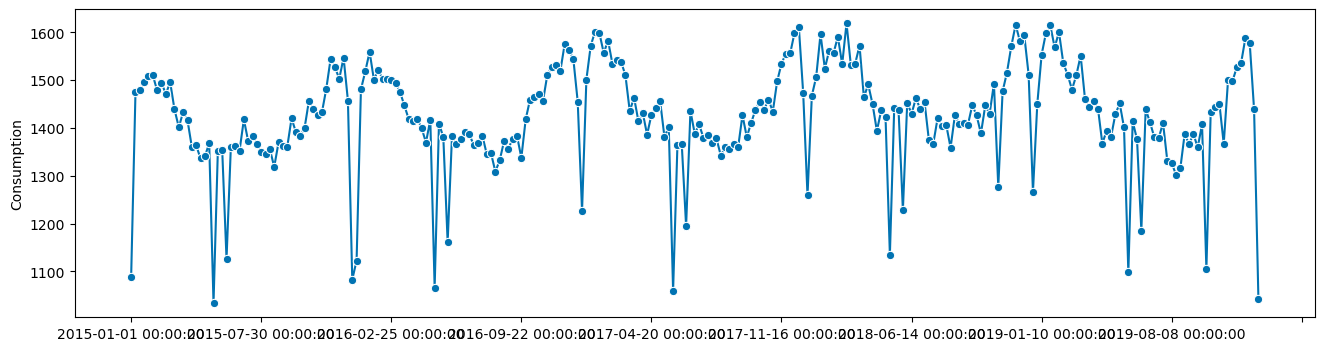

In [9]:
aeon.utils.plotting.plot_series(y);

Для разделения данных воспользуемся функцией `temporal_train_test_split`, которая позволяет адаптировать разделение данных не разрушая временные зависимости в данных. Отметим, что данная функция не единственный тип разделения данных. Более подробную информацию можно найти [тут](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=24f6be86f95bfc1ec246dee7dcdd455e0a84a872&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c616e2d747572696e672d696e737469747574652f736b74696d652f323466366265383666393562666331656332343664656537646364643435356530613834613837322f6578616d706c65732f77696e646f775f73706c6974746572732e6970796e62&logged_in=false&nwo=alan-turing-institute%2Fsktime&path=examples%2Fwindow_splitters.ipynb&platform=android&repository_id=156401841&repository_type=Repository&version=98).

Check splitted data size: Train: 144, Test: 117


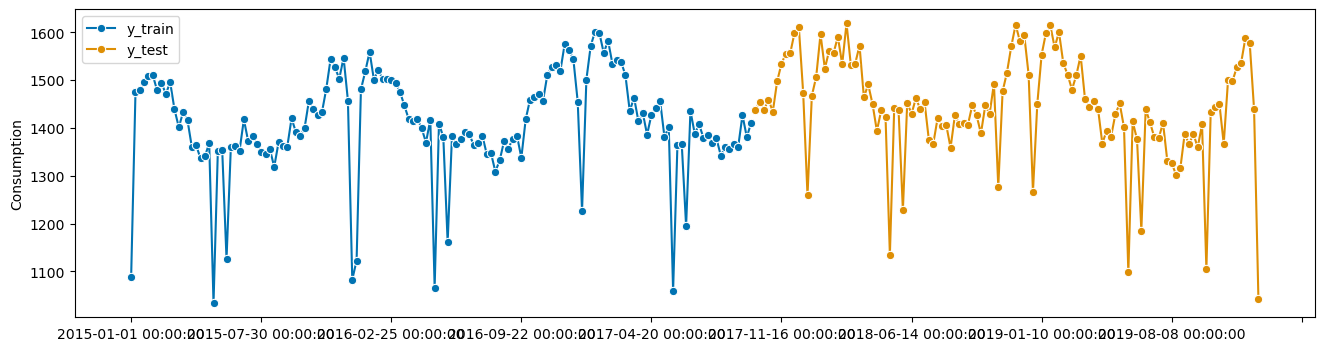

In [10]:
TEST_SIZE = int(0.45*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

aeon.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

Помимо разделения данных на тренированные и тестовые предсказание в `sktime` может потребовать т.н. `forecasting horizon` - то есть непосредственного указания числа предсказываемых значений. Такой горизонт предсказания можно задавать по разному, при помощи массива или объекта класса `ForecastingHorizon`. Последний способ предоставляет более развитый инструментарий.

Для начала давайте попробуем выполнить наивное предсказание. То есть каждое следующее предсказанное значение будет лишь копией предыдущего, начиная с последнего значение тренировочной выборки.

Мы полагаем, что не точность данного предсказания очевидна, однако, давайте все же проверим ошибку. Для этого воспользуемся симметричной средней процентной ошибкой (<b>symmetry Mean Average Percentage Error, sMAPE</b>) 
    $$ sMAPE =2\frac{1}{H}\sum_{i=1}^{H} \frac{|y(h_i) − \hat{y}(h_i)|}{|y(h_i)| + |\hat{y}(h_i)|}
 $$
    
    


sMAPE = 0.061


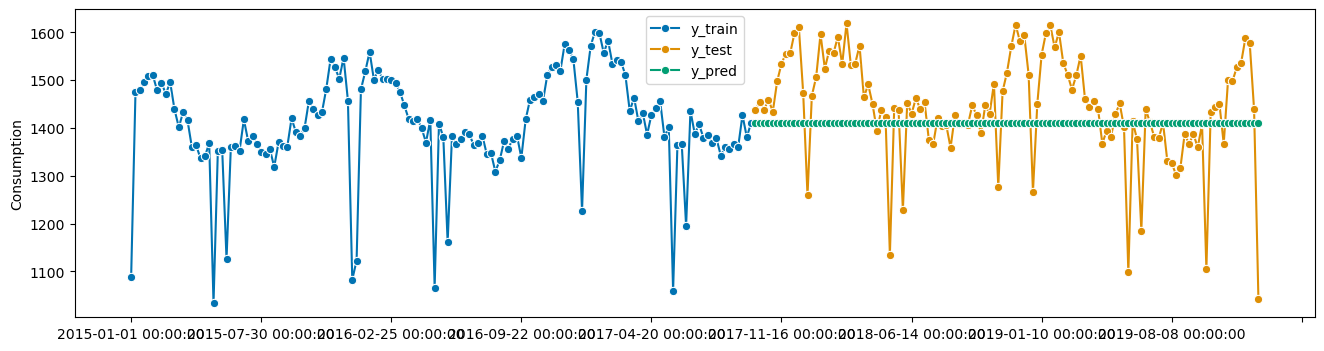

In [11]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Также давайте попробуем оценить точность наивного сезонного предсказания.

sMAPE = 0.043


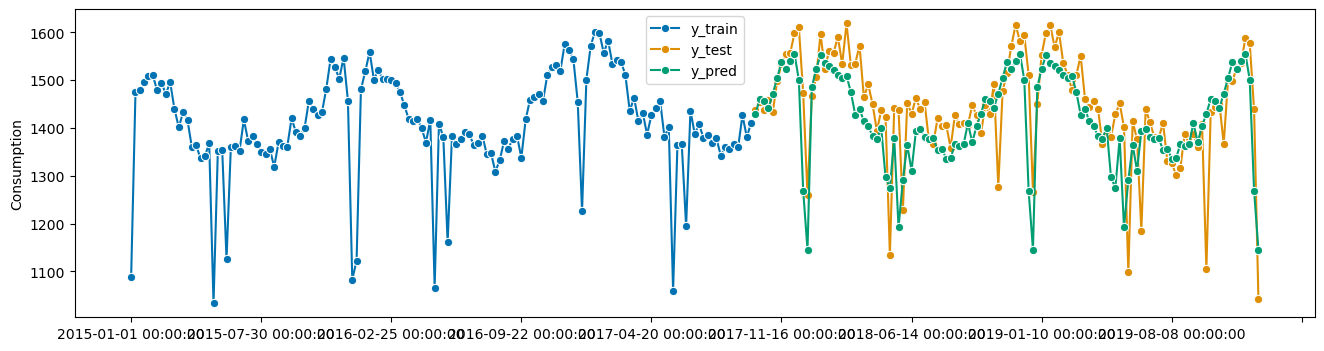

In [12]:
SEASON = 52

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Более продвинутым вариантом предсказателей является Семейство методов на основе экспоненциального сглаживания   (`Exponential Smoothing`, `Holt-Winter`). Давайте посмотрим на их работу. Для начала оценим точность наиболее простого варианта `Simple Exponential Smoothing`.

sMAPE = 0.066


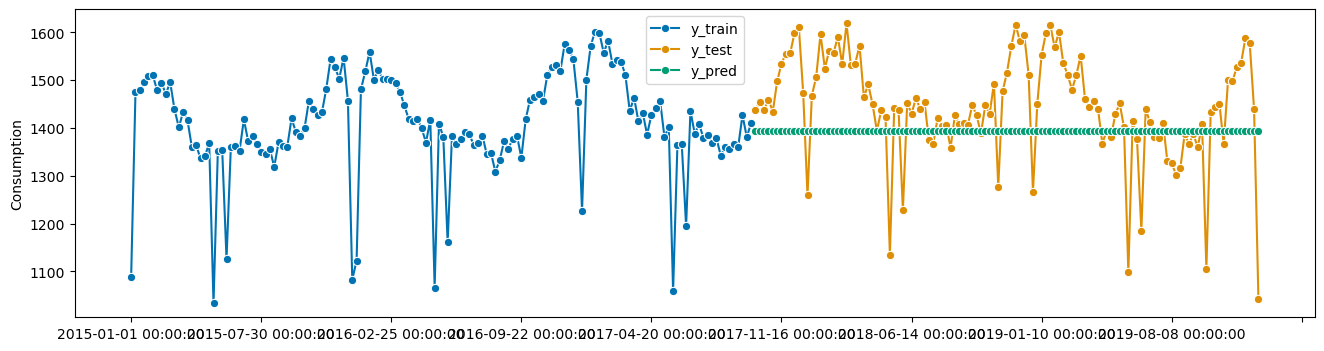

In [13]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.072


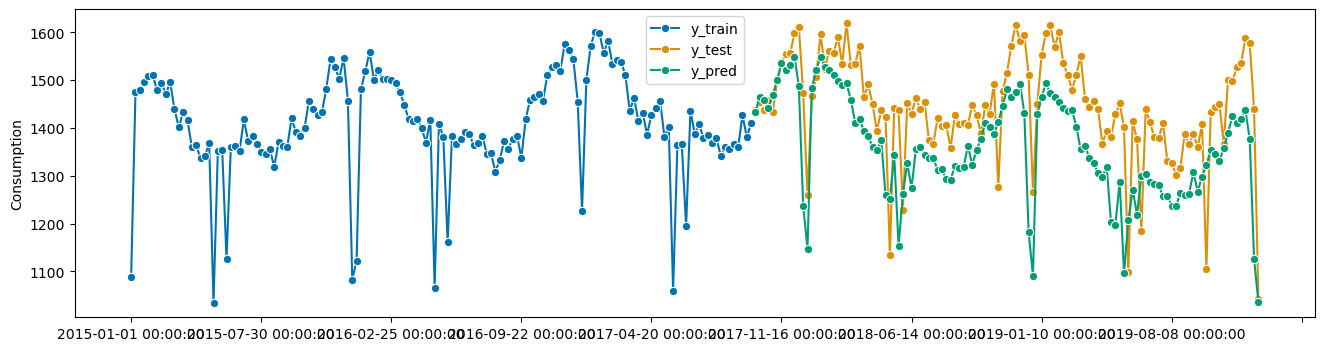

In [14]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)



forecaster = holt_winter

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')


Точность в предыдущих случаях оставляла желать лучшего. Однако, теперь давайте посмотрим на работу более сложных методов экспоненциального сглаживания. 

sMAPE = 0.048


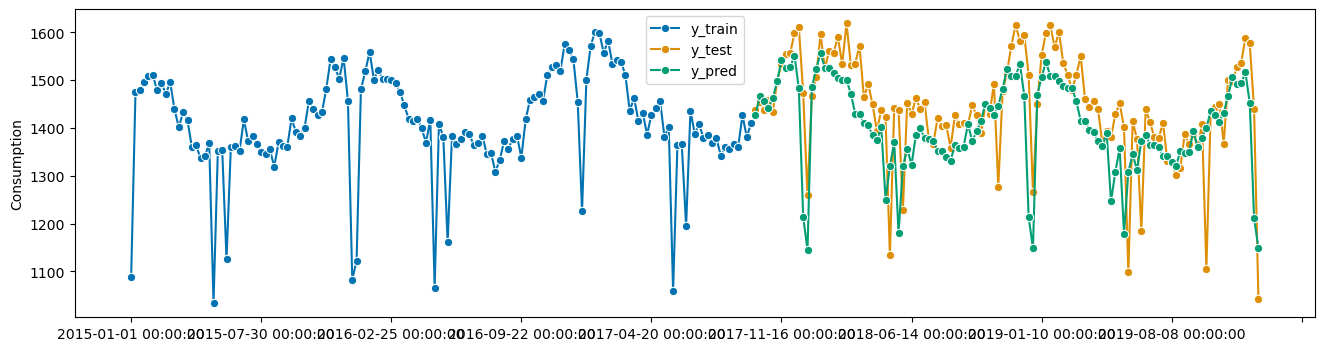

In [15]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = EnsembleForecaster(
    [
#         ("ses", ses),
#         ("holt", holt),
#         ("damped", damped_holt),
        ("holt-winter",holt_winter),
#         ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
#         ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
#         ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)        
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

В общем случае пакет `sktime` позволяет использовать автоматизированный подбор параметров модели экспоненциального сглаживания. Для этого может быть использован пакет `AutoETS`. Модель, реализуемая данным пакетом также называется `Error-Trend-Season (ETS)`. В случае необходимости исследователь может вручную задать параметры модели, в формате ETS(X,X,X)s</b>, где <b>X может быть N-None, A-additive, M-multiplicative, Ad-additive dumped, s-период сезона или None</b>. 

Частными примерами модели ETS являются:
* Simple Exponential smoothing ETS(A,N,N).  
* Triple Exponential smoothing ETS(A,A,A). 
* и многие другие.
    

sMAPE = 0.046


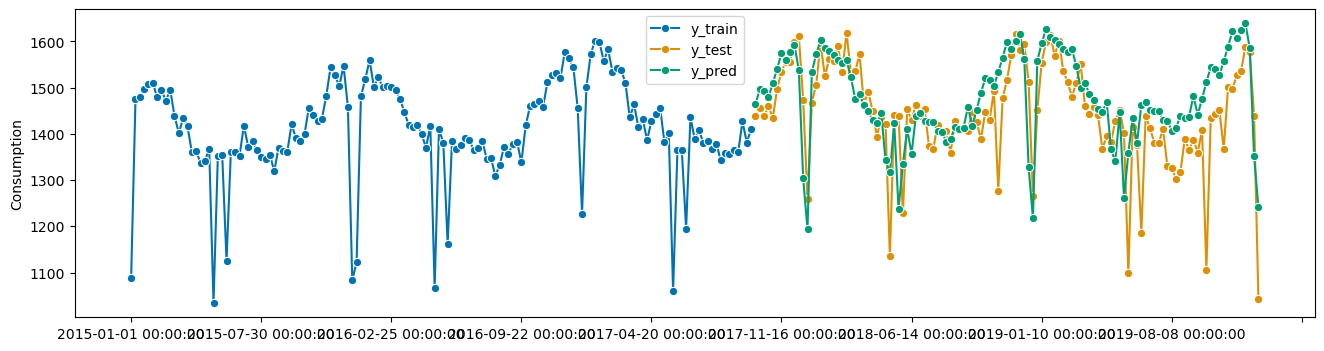

In [16]:
from aeon.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=SEASON, n_jobs=-1)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Другим методом оценки данных с вилянием сезонности и тренда является использование предварительной декомпозиции  временного ряда. Одним из наиболее простых методов декомпозиции является разделение на тренд, сезонность и остаток.  Давайте посмотрим на то, как будут выглядеть результаты такого разложения.

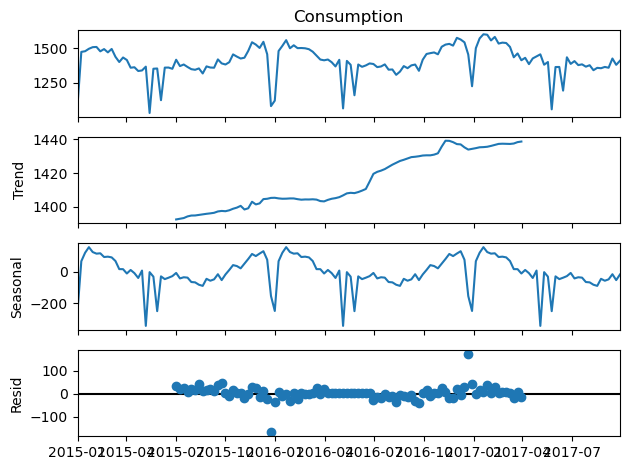

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='additive', period = 52)
result.plot();

В рамках пакета `SKTime` разложение можно выполнить при помощи объектов класса `Deseasonalizer` и `Detrender`.

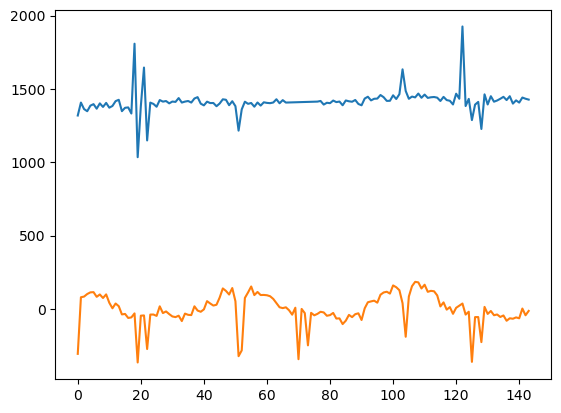

In [18]:
deseason = Deseasonalizer(model="multiplicative", sp=52)
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(deseason.fit_transform(y_train.values))
plt.plot(detrend.fit_transform(y_train.values))

Посмотрим на работу наиболее простого экспоненциального сглаживания с использованием разложения. Для этого будем использовать контейнер `TransformedTargetForecaster` - который является некоторым аналогом пайплайна.

sMAPE = 0.042


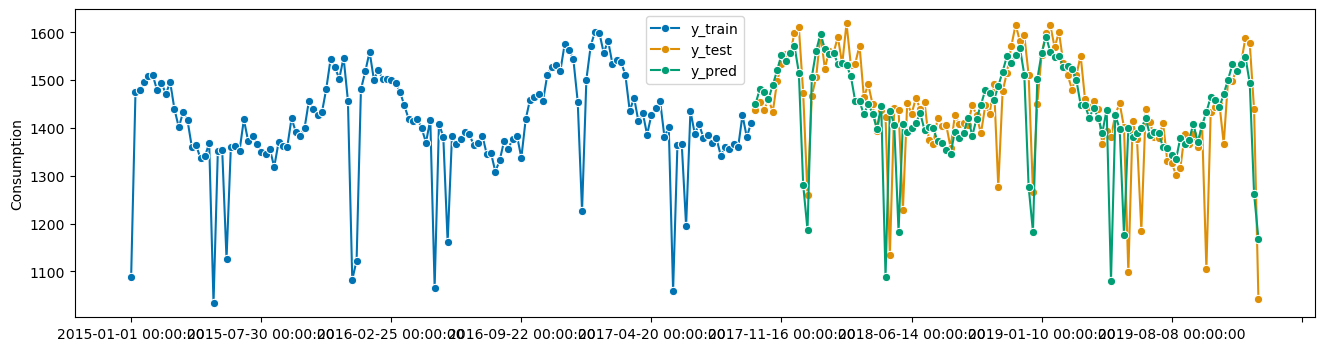

In [19]:
SEASON = 52

fh = ForecastingHorizon(y_test.index, is_relative=False)

# объек предсказатель
ses         = ExponentialSmoothing()

# пайплайн
forecaster = TransformedTargetForecaster(
                steps=[
                ("deseasonalize", Deseasonalizer(model="multiplicative", sp=SEASON)),
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
                ("forecaster", ses)
                ])
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)

# Результаты
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

В конце также давайте посмотрим несколько современных методов регрессии, разработанных для временных рядов и представленных в рамках пакета `SKTime`.

ThetaForecaster - метод предсказания временных рядов на основе экспоненциального сглаживания для модели с дрейфом тренда (случайный тренд). 

sMAPE = 0.044


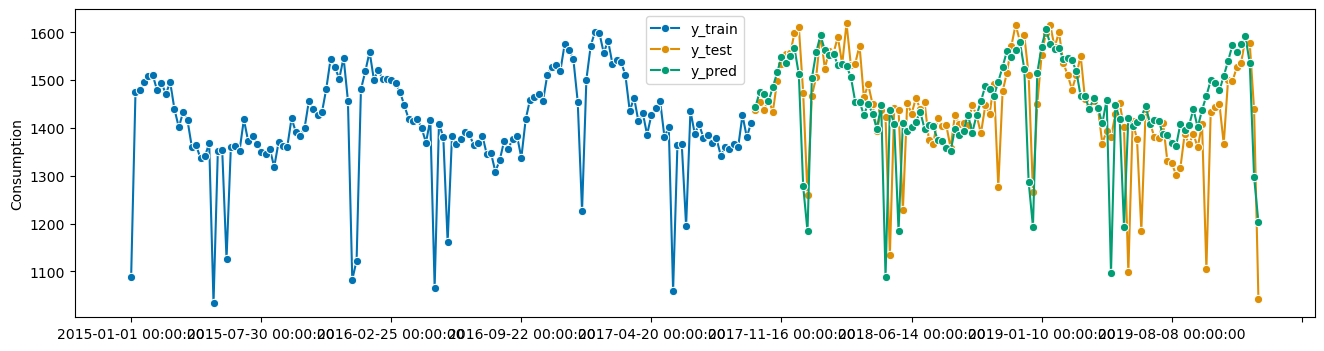

In [20]:
forecaster = ThetaForecaster(sp=SEASON)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

TBATS - метод на основе простого преобразования временного ряда (BOX-COX) и  затем использования отдельно предсказания для тренда, сезонной части и сложной модели ряда (ARMA). Метод подходит для временных рядов с несколькими сезонными составляющими.

sMAPE = 0.040


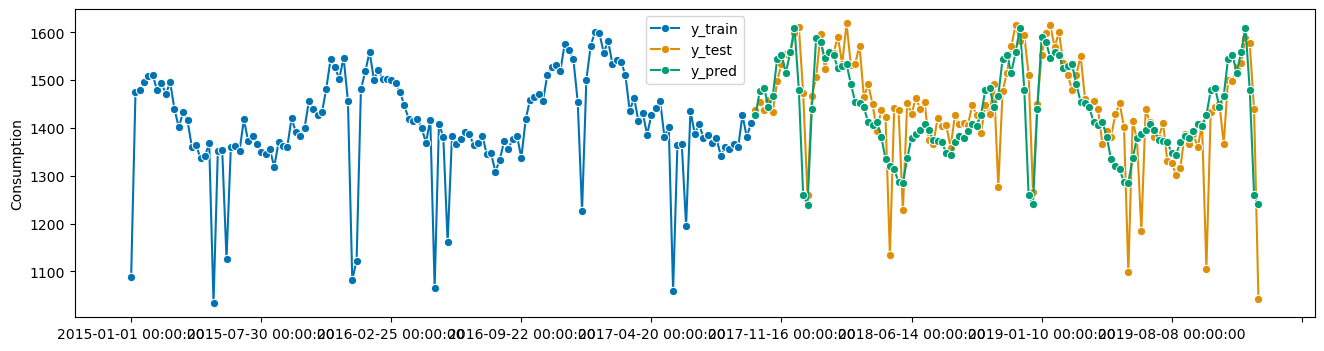

In [21]:
forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=SEASON,
    use_arma_errors=True,
    n_jobs=-1)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.042


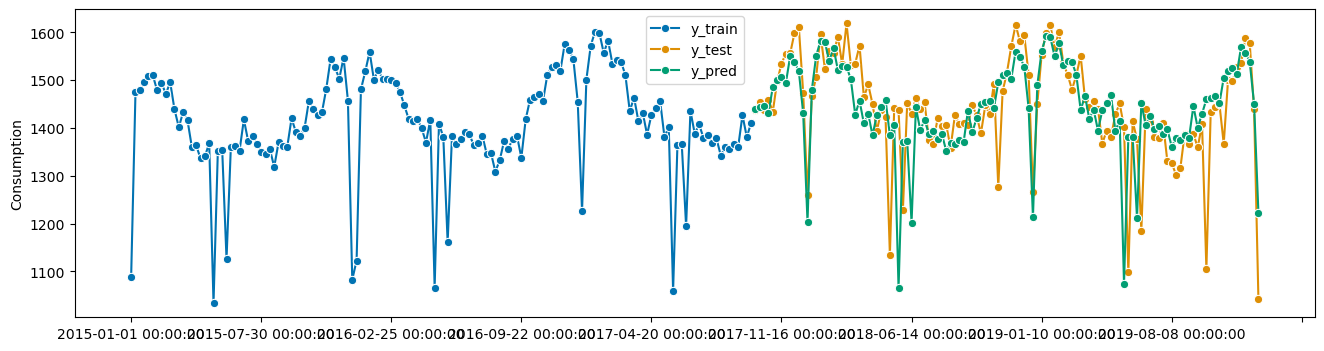

In [25]:
from aeon.forecasting.structural import UnobservedComponents

forecaster = UnobservedComponents(
    level="local linear trend", freq_seasonal=[{"period": 52, "harmonics": 110}]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Prophet - метод предсказания временных рядов на основе т.н. обобщенной регрессии для модели бизнес процессов, которая включает тренд с точками перегиба и насыщением, несколько компонент сезонности и редкие, но регулярные события (типа выходных дней). 

11:26:57 - cmdstanpy - INFO - Chain [1] start processing
11:26:57 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.033


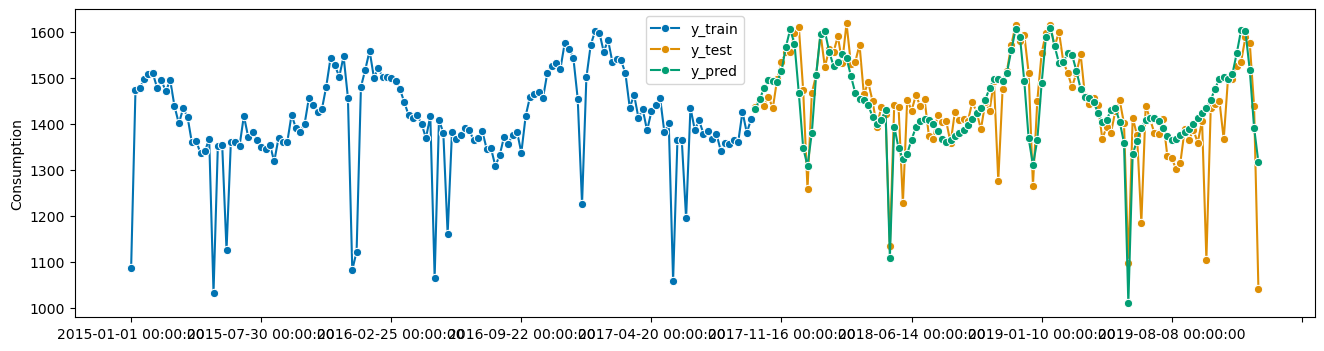

In [26]:
forecaster = Prophet(
                    seasonality_mode='additive',
                    n_changepoints=int(len(y_train) / 4),
                    add_country_holidays={'country_name': 'Germany'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

 # Использование пакета Scikit-learn для предсказаний

 Такой горизонт можно описать моделью `seq2seq` когда одна последовательность данных подается на вход модели и на выходе вычисляется новая - предсказанная последовательность. Однако, такой путь не совсем удачная идея для `Scikit-learn`. Отметим, что в пакете `Scikit-learn` принято задавать данные в "табличном" виде, то есть вектор входных данных - одно или несколько выходных.  Для того, чтобы представить временной ряд в таком виде есть несколько техник. Мы воспользуемся одной из них <b><code>recursive reduction</code></b>.  

Идея техники <b><code>recursive reduction </code></b> достаточно проста, принцип работы показана ниже.  Принцип заключается в движении по меткам ряда окна, размером с тренировочную выборку, таким образом, что каждый следующий семпл ответ связан с положением окна. Данная техника может быть реализована в рамках  функции `make_reduction`. Отметим, что в общем случае [данная функция имеет и другие режимы редукции](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html). 

<img src="https://www.cienciadedatos.net/images/transform_timeseries.gif" width = 500px>

Также важно заметить, что рекурсивная редукция может быть реализована только в тренировочном режиме. В тестовом режиме такая редукция сводится лишь к 1-step regression или к регрессии с горизонтом при помощи подстановки предсказанных значений.

В качестве примера рассмотрим регрессию ближайших соседей.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 15

regressor  = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Попробуем также провести регрессию с использованием пайплайна.

In [ ]:
regressor  = KNeighborsRegressor(n_neighbors=3)

forecaster = TransformedTargetForecaster([
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
        ( "forecast", make_reduction(
                            regressor,
                            scitype="tabular-regressor",
                            window_length=REGRESSION_WINDOW,
                            strategy="recursive",)),
    ])

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

В некоторых случаях также можно использовать методы поиска лучших гиперпараметров. Пример ниже позволяет найти наилучшие гиперпараметры как для оценки из `sklearn`, так и для параметра из `aeon`.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from aeon.forecasting.compose import make_reduction
from aeon.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

param_grid = {"window_length": [10, 12, 15], "estimator__n_neighbors": [1,2,3,4]}

regressor = KNeighborsRegressor()

forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

# Предварительные данные
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.7), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(pd.DataFrame(y_train))

y_pred = gscv.predict(fh)
y_pred = y_pred.squeeze()


plot_series(y_train, y_test,y_pred,  labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

print('Best paramters',gscv.best_params_)